<a href="https://colab.research.google.com/github/rajendranandana/Analisis_Sentimen_HotelKeprabon/blob/main/AnalisisSentimen_HotelKeprabon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
RAW = '/content/drive/MyDrive/revisi skripsi/dataset_revisi.xlsx'
CLEAN = '/content/drive/MyDrive/revisi skripsi/clean_data.csv'
KAMUS = '/content/drive/MyDrive/revisi skripsi/kamuskatabaku.csv'
HASIL = '/content/drive/MyDrive/revisi skripsi/preprocessed.xlsx'
STEM = '/content/drive/MyDrive/revisi skripsi/stem.txt'
INSET = '/content/drive/MyDrive/revisi skripsi/InSet-Lexicon.txt'
BALANCED = '/content/drive/MyDrive/revisi skripsi/balanced.csv'
TFIDF = '/content/drive/MyDrive/revisi skripsi/tfidf.csv'
LABELED = '/content/drive/MyDrive/revisi skripsi/labeled.xlsx'

In [ ]:
import pandas as pd

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

!pip install Sastrawi
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
raw_data = pd.read_excel(RAW)
raw_data

,nama,rating,ulasan
0,Arif A.,10,"Hotel murah tapi bersih, meskipun terlihat tua..."
1,Surya F.,10,"Untuk harga segitu, cukup lumayan. Lokasi stra..."
2,B***a,10,Bapak yang melayani sangat ramah. Hotelnya nya...
3,Sukesih M.,10,"Puas deh nginep di sini, murah tapi ga murahan."
4,S***i,10,oke banget menginap dengan budget oke
...,...,...,...
1334,Boby Canary,"5,0",Ada minibar. Suasana sangat hangat. Pelayanan ...
1335,Boby Canary,"5,0",Ada minibar. Suasana sangat hangat. Pelayanan ...
1336,SA,"1,0",ada kecoanya semoga kedepan makin bagus. ac ny...
1337,sharlyne sharlyne,"1,0",AC g nyala air panas alakadarnya


In [ ]:
missing_values = raw_data.isnull().sum()
print("Missing Values:\n", missing_values)

duplicates = raw_data.duplicated().sum()
print(f"Jumlah data duplikat: {duplicates}")


Missing Values:
 nama       1
rating     0
ulasan    38
dtype: int64
Jumlah data duplikat: 80


In [ ]:
raw_data = raw_data.drop_duplicates()

raw_data = raw_data.dropna(subset=['nama','ulasan'])

missing_values_after = raw_data.isnull().sum()
print("Missing Values After Processing:\n", missing_values_after)

duplicates_after = raw_data.duplicated().sum()
print(f"Jumlah data duplikat setelah dihapus: {duplicates_after}")

raw_data.to_csv(CLEAN, index=False)


Missing Values After Processing:
 nama      0
rating    0
ulasan    0
dtype: int64
Jumlah data duplikat setelah dihapus: 0


In [ ]:
cleaned_data = pd.read_csv(CLEAN)
cleaned_data

,nama,rating,ulasan
0,Arif A.,10,"Hotel murah tapi bersih, meskipun terlihat tua..."
1,Surya F.,10,"Untuk harga segitu, cukup lumayan. Lokasi stra..."
2,B***a,10,Bapak yang melayani sangat ramah. Hotelnya nya...
3,Sukesih M.,10,"Puas deh nginep di sini, murah tapi ga murahan."
4,S***i,10,oke banget menginap dengan budget oke
...,...,...,...
1217,AK,"3,0",Agak kurang tapi deket kota
1218,Boby Canary,"5,0",Ada minibar. Suasana sangat hangat. Pelayanan ...
1219,SA,"1,0",ada kecoanya semoga kedepan makin bagus. ac ny...
1220,sharlyne sharlyne,"1,0",AC g nyala air panas alakadarnya


In [ ]:
def remove_URL(ulasan):
    if ulasan is not None and isinstance(ulasan, str):
        url = re.compile(r'(https?://\S+|www\.\S+\.\S+)')
        return url.sub(r'', ulasan)
    else:
        return ulasan

def remove_html(ulasan):
    if ulasan is not None and isinstance(ulasan, str):
        html = re.compile(r'<.*?>')
        return html.sub(r'', ulasan)
    else:
        return ulasan

def remove_emoji(ulasan):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons # Fixed: Changed \U00001F64F to \U0001F64F
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U0001F004-\U0001F0CF"
        u"\U0001F1E0-\U0001F1FF"
                        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', ulasan)

def remove_symbols(ulasan):
    if ulasan is not None and isinstance(ulasan, str):
        ulasan = re.sub(r'[^a-zA-Z0-9\s]', ' ', ulasan)
        return ulasan
    else:
        return ulasan

def remove_numbers(ulasan):
    if ulasan is not None and isinstance(ulasan, str):
        ulasan = re.sub(r'\d+', '', ulasan)
        return ulasan
    else:
        return ulasan

In [ ]:
cleaned_data['cleaning'] = cleaned_data['ulasan'].apply(lambda x: remove_URL(x))
cleaned_data['cleaning'] = cleaned_data['cleaning'].apply(lambda x: remove_html(x))
cleaned_data['cleaning'] = cleaned_data['cleaning'].apply(lambda x: remove_emoji(x))
cleaned_data['cleaning'] = cleaned_data['cleaning'].apply(lambda x: remove_symbols(x))
cleaned_data['cleaning'] = cleaned_data['cleaning'].apply(lambda x: remove_numbers(x))
cleaned_data['ulasan'] = cleaned_data['ulasan'].str.replace('\\\\', '', regex=True)
cleaned_data

,nama,rating,ulasan,cleaning
0,Arif A.,10,"Hotel murah tapi bersih, meskipun terlihat tua...",Hotel murah tapi bersih meskipun terlihat tua...
1,Surya F.,10,"Untuk harga segitu, cukup lumayan. Lokasi stra...",Untuk harga segitu cukup lumayan Lokasi stra...
2,B***a,10,Bapak yang melayani sangat ramah. Hotelnya nya...,Bapak yang melayani sangat ramah Hotelnya nya...
3,Sukesih M.,10,"Puas deh nginep di sini, murah tapi ga murahan.",Puas deh nginep di sini murah tapi ga murahan
4,S***i,10,oke banget menginap dengan budget oke,oke banget menginap dengan budget oke
...,...,...,...,...
1217,AK,"3,0",Agak kurang tapi deket kota,Agak kurang tapi deket kota
1218,Boby Canary,"5,0",Ada minibar. Suasana sangat hangat. Pelayanan ...,Ada minibar Suasana sangat hangat Pelayanan ...
1219,SA,"1,0",ada kecoanya semoga kedepan makin bagus. ac ny...,ada kecoanya semoga kedepan makin bagus ac ny...
1220,sharlyne sharlyne,"1,0",AC g nyala air panas alakadarnya,AC g nyala air panas alakadarnya


In [ ]:
def case_folding(ulasan):
    if isinstance(ulasan, str):
        return ulasan.lower()
    else:
        return ulasan

In [ ]:
cleaned_data['case_folding'] = cleaned_data['cleaning'].apply(lambda x: case_folding(x))
cleaned_data

,nama,rating,ulasan,cleaning,case_folding
0,Arif A.,10,"Hotel murah tapi bersih, meskipun terlihat tua...",Hotel murah tapi bersih meskipun terlihat tua...,hotel murah tapi bersih meskipun terlihat tua...
1,Surya F.,10,"Untuk harga segitu, cukup lumayan. Lokasi stra...",Untuk harga segitu cukup lumayan Lokasi stra...,untuk harga segitu cukup lumayan lokasi stra...
2,B***a,10,Bapak yang melayani sangat ramah. Hotelnya nya...,Bapak yang melayani sangat ramah Hotelnya nya...,bapak yang melayani sangat ramah hotelnya nya...
3,Sukesih M.,10,"Puas deh nginep di sini, murah tapi ga murahan.",Puas deh nginep di sini murah tapi ga murahan,puas deh nginep di sini murah tapi ga murahan
4,S***i,10,oke banget menginap dengan budget oke,oke banget menginap dengan budget oke,oke banget menginap dengan budget oke
...,...,...,...,...,...
1217,AK,"3,0",Agak kurang tapi deket kota,Agak kurang tapi deket kota,agak kurang tapi deket kota
1218,Boby Canary,"5,0",Ada minibar. Suasana sangat hangat. Pelayanan ...,Ada minibar Suasana sangat hangat Pelayanan ...,ada minibar suasana sangat hangat pelayanan ...
1219,SA,"1,0",ada kecoanya semoga kedepan makin bagus. ac ny...,ada kecoanya semoga kedepan makin bagus ac ny...,ada kecoanya semoga kedepan makin bagus ac ny...
1220,sharlyne sharlyne,"1,0",AC g nyala air panas alakadarnya,AC g nyala air panas alakadarnya,ac g nyala air panas alakadarnya


In [ ]:
def replace_taboo_words(ulasan, kamus_tidak_baku):
    if isinstance(ulasan, str):
        words = ulasan.split()
        replace_words = []
        for word in words:
            if word in kamus_tidak_baku:
                baku_word = kamus_tidak_baku[word]
                if isinstance(baku_word, str) and all(char.isalpha() or char.isspace() for char in baku_word):
                    replace_words.append(baku_word)
                else:
                    replace_words.append(word)
            else:
                replace_words.append(word)
        replaced_text = ' '.join(replace_words)
    else:
        replaced_text = ''
    return replaced_text

In [ ]:
kamus_data = pd.read_csv(KAMUS, delimiter=';')
kamus_tidak_baku = dict(zip(kamus_data['tidak_baku'], kamus_data['kata_baku']))

In [ ]:
cleaned_data['normalisasi'] = cleaned_data['case_folding'].apply(lambda x: replace_taboo_words(x, kamus_tidak_baku))
cleaned_data

,nama,rating,ulasan,cleaning,case_folding,normalisasi
0,Arif A.,10,"Hotel murah tapi bersih, meskipun terlihat tua...",Hotel murah tapi bersih meskipun terlihat tua...,hotel murah tapi bersih meskipun terlihat tua...,hotel murah tapi bersih meskipun terlihat tua ...
1,Surya F.,10,"Untuk harga segitu, cukup lumayan. Lokasi stra...",Untuk harga segitu cukup lumayan Lokasi stra...,untuk harga segitu cukup lumayan lokasi stra...,untuk harga segitu cukup lumayan lokasi strate...
2,B***a,10,Bapak yang melayani sangat ramah. Hotelnya nya...,Bapak yang melayani sangat ramah Hotelnya nya...,bapak yang melayani sangat ramah hotelnya nya...,bapak yang melayani sangat ramah hotelnya nyam...
3,Sukesih M.,10,"Puas deh nginep di sini, murah tapi ga murahan.",Puas deh nginep di sini murah tapi ga murahan,puas deh nginep di sini murah tapi ga murahan,puas deh menginap di sini murah tapi tidak mur...
4,S***i,10,oke banget menginap dengan budget oke,oke banget menginap dengan budget oke,oke banget menginap dengan budget oke,oke banget menginap dengan biaya oke
...,...,...,...,...,...,...
1217,AK,"3,0",Agak kurang tapi deket kota,Agak kurang tapi deket kota,agak kurang tapi deket kota,agak kurang tapi dekat kota
1218,Boby Canary,"5,0",Ada minibar. Suasana sangat hangat. Pelayanan ...,Ada minibar Suasana sangat hangat Pelayanan ...,ada minibar suasana sangat hangat pelayanan ...,ada minibar suasana sangat hangat pelayanan sa...
1219,SA,"1,0",ada kecoanya semoga kedepan makin bagus. ac ny...,ada kecoanya semoga kedepan makin bagus ac ny...,ada kecoanya semoga kedepan makin bagus ac ny...,ada kecoanya semoga kedepan makin bagus ac ya ...
1220,sharlyne sharlyne,"1,0",AC g nyala air panas alakadarnya,AC g nyala air panas alakadarnya,ac g nyala air panas alakadarnya,ac tidak nyala air panas alakadarnya


In [ ]:
def tokenize(text):
    tokens = text.split()
    return tokens

cleaned_data['tokenization'] = cleaned_data['normalisasi'].apply(lambda x: tokenize(x))
cleaned_data

,nama,rating,ulasan,cleaning,case_folding,normalisasi,tokenization
0,Arif A.,10,"Hotel murah tapi bersih, meskipun terlihat tua...",Hotel murah tapi bersih meskipun terlihat tua...,hotel murah tapi bersih meskipun terlihat tua...,hotel murah tapi bersih meskipun terlihat tua ...,"[hotel, murah, tapi, bersih, meskipun, terliha..."
1,Surya F.,10,"Untuk harga segitu, cukup lumayan. Lokasi stra...",Untuk harga segitu cukup lumayan Lokasi stra...,untuk harga segitu cukup lumayan lokasi stra...,untuk harga segitu cukup lumayan lokasi strate...,"[untuk, harga, segitu, cukup, lumayan, lokasi,..."
2,B***a,10,Bapak yang melayani sangat ramah. Hotelnya nya...,Bapak yang melayani sangat ramah Hotelnya nya...,bapak yang melayani sangat ramah hotelnya nya...,bapak yang melayani sangat ramah hotelnya nyam...,"[bapak, yang, melayani, sangat, ramah, hotelny..."
3,Sukesih M.,10,"Puas deh nginep di sini, murah tapi ga murahan.",Puas deh nginep di sini murah tapi ga murahan,puas deh nginep di sini murah tapi ga murahan,puas deh menginap di sini murah tapi tidak mur...,"[puas, deh, menginap, di, sini, murah, tapi, t..."
4,S***i,10,oke banget menginap dengan budget oke,oke banget menginap dengan budget oke,oke banget menginap dengan budget oke,oke banget menginap dengan biaya oke,"[oke, banget, menginap, dengan, biaya, oke]"
...,...,...,...,...,...,...,...
1217,AK,"3,0",Agak kurang tapi deket kota,Agak kurang tapi deket kota,agak kurang tapi deket kota,agak kurang tapi dekat kota,"[agak, kurang, tapi, dekat, kota]"
1218,Boby Canary,"5,0",Ada minibar. Suasana sangat hangat. Pelayanan ...,Ada minibar Suasana sangat hangat Pelayanan ...,ada minibar suasana sangat hangat pelayanan ...,ada minibar suasana sangat hangat pelayanan sa...,"[ada, minibar, suasana, sangat, hangat, pelaya..."
1219,SA,"1,0",ada kecoanya semoga kedepan makin bagus. ac ny...,ada kecoanya semoga kedepan makin bagus ac ny...,ada kecoanya semoga kedepan makin bagus ac ny...,ada kecoanya semoga kedepan makin bagus ac ya ...,"[ada, kecoanya, semoga, kedepan, makin, bagus,..."
1220,sharlyne sharlyne,"1,0",AC g nyala air panas alakadarnya,AC g nyala air panas alakadarnya,ac g nyala air panas alakadarnya,ac tidak nyala air panas alakadarnya,"[ac, tidak, nyala, air, panas, alakadarnya]"


In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
custom_stopwords = ["sih","sihh","icu","next","deh","biar","firts","haha","pas","yan","yen","aaahhh","yuk","an","don","t","nb","jm","sok","i","b","eh","ha","n","o","xixixi","dll","tl","doang","xcm","looooo","lah","mbok","fo","kok","tra","oka","kah","hemmm","hihi","nya","loh","hhuuaa","via","huhu","mah","ha","eh","hloh","aaahhh","so","looooo","loo","dis","kog","tru","gan","ttu","amp","cuy","kek",""]
kata_dilindungi = {'tidak','sangat','ada','kurang'}
stopwords_indonesian = set(stopwords.words('indonesian'))
stopwords_all = (stopwords_indonesian.union(custom_stopwords)) - kata_dilindungi

def remove_stopwords(text):
    return ' '.join([word for word in text if word not in stopwords_all])

cleaned_data['stopword'] = cleaned_data['tokenization'].apply(lambda x: remove_stopwords(x))
cleaned_data


,nama,rating,ulasan,cleaning,case_folding,normalisasi,tokenization,stopword
0,Arif A.,10,"Hotel murah tapi bersih, meskipun terlihat tua...",Hotel murah tapi bersih meskipun terlihat tua...,hotel murah tapi bersih meskipun terlihat tua...,hotel murah tapi bersih meskipun terlihat tua ...,"[hotel, murah, tapi, bersih, meskipun, terliha...",hotel murah bersih tua terawat expect ya prope...
1,Surya F.,10,"Untuk harga segitu, cukup lumayan. Lokasi stra...",Untuk harga segitu cukup lumayan Lokasi stra...,untuk harga segitu cukup lumayan lokasi stra...,untuk harga segitu cukup lumayan lokasi strate...,"[untuk, harga, segitu, cukup, lumayan, lokasi,...",harga segitu lumayan lokasi strategis rekomen ...
2,B***a,10,Bapak yang melayani sangat ramah. Hotelnya nya...,Bapak yang melayani sangat ramah Hotelnya nya...,bapak yang melayani sangat ramah hotelnya nya...,bapak yang melayani sangat ramah hotelnya nyam...,"[bapak, yang, melayani, sangat, ramah, hotelny...",melayani sangat ramah hotelnya nyaman menginap
3,Sukesih M.,10,"Puas deh nginep di sini, murah tapi ga murahan.",Puas deh nginep di sini murah tapi ga murahan,puas deh nginep di sini murah tapi ga murahan,puas deh menginap di sini murah tapi tidak mur...,"[puas, deh, menginap, di, sini, murah, tapi, t...",puas menginap murah tidak murahan
4,S***i,10,oke banget menginap dengan budget oke,oke banget menginap dengan budget oke,oke banget menginap dengan budget oke,oke banget menginap dengan biaya oke,"[oke, banget, menginap, dengan, biaya, oke]",oke banget menginap biaya oke
...,...,...,...,...,...,...,...,...
1217,AK,"3,0",Agak kurang tapi deket kota,Agak kurang tapi deket kota,agak kurang tapi deket kota,agak kurang tapi dekat kota,"[agak, kurang, tapi, dekat, kota]",kurang kota
1218,Boby Canary,"5,0",Ada minibar. Suasana sangat hangat. Pelayanan ...,Ada minibar Suasana sangat hangat Pelayanan ...,ada minibar suasana sangat hangat pelayanan ...,ada minibar suasana sangat hangat pelayanan sa...,"[ada, minibar, suasana, sangat, hangat, pelaya...",ada minibar suasana sangat hangat pelayanan sa...
1219,SA,"1,0",ada kecoanya semoga kedepan makin bagus. ac ny...,ada kecoanya semoga kedepan makin bagus ac ny...,ada kecoanya semoga kedepan makin bagus ac ny...,ada kecoanya semoga kedepan makin bagus ac ya ...,"[ada, kecoanya, semoga, kedepan, makin, bagus,...",ada kecoanya semoga kedepan bagus ac ya dingin
1220,sharlyne sharlyne,"1,0",AC g nyala air panas alakadarnya,AC g nyala air panas alakadarnya,ac g nyala air panas alakadarnya,ac tidak nyala air panas alakadarnya,"[ac, tidak, nyala, air, panas, alakadarnya]",ac tidak nyala air panas alakadarnya


In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

cleaned_data['stemmer']=cleaned_data['stopword'].apply(stem_text)
cleaned_data.to_excel(HASIL, index=False)
cleaned_data

,nama,rating,ulasan,cleaning,case_folding,normalisasi,tokenization,stopword,stemmer
0,Arif A.,10,"Hotel murah tapi bersih, meskipun terlihat tua...",Hotel murah tapi bersih meskipun terlihat tua...,hotel murah tapi bersih meskipun terlihat tua...,hotel murah tapi bersih meskipun terlihat tua ...,"[hotel, murah, tapi, bersih, meskipun, terliha...",hotel murah bersih tua terawat expect ya prope...,hotel murah bersih tua awat expect ya properti...
1,Surya F.,10,"Untuk harga segitu, cukup lumayan. Lokasi stra...",Untuk harga segitu cukup lumayan Lokasi stra...,untuk harga segitu cukup lumayan lokasi stra...,untuk harga segitu cukup lumayan lokasi strate...,"[untuk, harga, segitu, cukup, lumayan, lokasi,...",harga segitu lumayan lokasi strategis rekomen ...,harga segitu lumayan lokasi strategis rekomen ...
2,B***a,10,Bapak yang melayani sangat ramah. Hotelnya nya...,Bapak yang melayani sangat ramah Hotelnya nya...,bapak yang melayani sangat ramah hotelnya nya...,bapak yang melayani sangat ramah hotelnya nyam...,"[bapak, yang, melayani, sangat, ramah, hotelny...",melayani sangat ramah hotelnya nyaman menginap,layan sangat ramah hotel nyaman inap
3,Sukesih M.,10,"Puas deh nginep di sini, murah tapi ga murahan.",Puas deh nginep di sini murah tapi ga murahan,puas deh nginep di sini murah tapi ga murahan,puas deh menginap di sini murah tapi tidak mur...,"[puas, deh, menginap, di, sini, murah, tapi, t...",puas menginap murah tidak murahan,puas inap murah tidak murah
4,S***i,10,oke banget menginap dengan budget oke,oke banget menginap dengan budget oke,oke banget menginap dengan budget oke,oke banget menginap dengan biaya oke,"[oke, banget, menginap, dengan, biaya, oke]",oke banget menginap biaya oke,oke banget inap biaya oke
...,...,...,...,...,...,...,...,...,...
1217,AK,"3,0",Agak kurang tapi deket kota,Agak kurang tapi deket kota,agak kurang tapi deket kota,agak kurang tapi dekat kota,"[agak, kurang, tapi, dekat, kota]",kurang kota,kurang kota
1218,Boby Canary,"5,0",Ada minibar. Suasana sangat hangat. Pelayanan ...,Ada minibar Suasana sangat hangat Pelayanan ...,ada minibar suasana sangat hangat pelayanan ...,ada minibar suasana sangat hangat pelayanan sa...,"[ada, minibar, suasana, sangat, hangat, pelaya...",ada minibar suasana sangat hangat pelayanan sa...,ada minibar suasana sangat hangat layan sangat...
1219,SA,"1,0",ada kecoanya semoga kedepan makin bagus. ac ny...,ada kecoanya semoga kedepan makin bagus ac ny...,ada kecoanya semoga kedepan makin bagus ac ny...,ada kecoanya semoga kedepan makin bagus ac ya ...,"[ada, kecoanya, semoga, kedepan, makin, bagus,...",ada kecoanya semoga kedepan bagus ac ya dingin,ada kecoanya moga depan bagus ac ya dingin
1220,sharlyne sharlyne,"1,0",AC g nyala air panas alakadarnya,AC g nyala air panas alakadarnya,ac g nyala air panas alakadarnya,ac tidak nyala air panas alakadarnya,"[ac, tidak, nyala, air, panas, alakadarnya]",ac tidak nyala air panas alakadarnya,ac tidak nyala air panas alakadarnya


In [ ]:
def stem_text(text):
    additional_words = {"nginap": "inap","nginep": "inap", "kesini": "sini", "gosipin":"gosip"}
    words = text.split()
    stemmed_words = []
    for word in words:
        if word in additional_words:
            stemmed_words.append(additional_words[word])
        else:
            stemmed_words.append(stemmer.stem(word))
    return ' '.join(stemmed_words)

cleaned_data['stemmer']=cleaned_data['stemmer'].apply(stem_text)
cleaned_data.to_excel(HASIL, index=False)
cleaned_data


,nama,rating,ulasan,cleaning,case_folding,normalisasi,tokenization,stopword,stemmer
0,Arif A.,10,"Hotel murah tapi bersih, meskipun terlihat tua...",Hotel murah tapi bersih meskipun terlihat tua...,hotel murah tapi bersih meskipun terlihat tua...,hotel murah tapi bersih meskipun terlihat tua ...,"[hotel, murah, tapi, bersih, meskipun, terliha...",hotel murah bersih tua terawat expect ya prope...,hotel murah bersih tua awat expect ya properti...
1,Surya F.,10,"Untuk harga segitu, cukup lumayan. Lokasi stra...",Untuk harga segitu cukup lumayan Lokasi stra...,untuk harga segitu cukup lumayan lokasi stra...,untuk harga segitu cukup lumayan lokasi strate...,"[untuk, harga, segitu, cukup, lumayan, lokasi,...",harga segitu lumayan lokasi strategis rekomen ...,harga segitu lumayan lokasi strategis rekomen ...
2,B***a,10,Bapak yang melayani sangat ramah. Hotelnya nya...,Bapak yang melayani sangat ramah Hotelnya nya...,bapak yang melayani sangat ramah hotelnya nya...,bapak yang melayani sangat ramah hotelnya nyam...,"[bapak, yang, melayani, sangat, ramah, hotelny...",melayani sangat ramah hotelnya nyaman menginap,layan sangat ramah hotel nyaman inap
3,Sukesih M.,10,"Puas deh nginep di sini, murah tapi ga murahan.",Puas deh nginep di sini murah tapi ga murahan,puas deh nginep di sini murah tapi ga murahan,puas deh menginap di sini murah tapi tidak mur...,"[puas, deh, menginap, di, sini, murah, tapi, t...",puas menginap murah tidak murahan,puas inap murah tidak murah
4,S***i,10,oke banget menginap dengan budget oke,oke banget menginap dengan budget oke,oke banget menginap dengan budget oke,oke banget menginap dengan biaya oke,"[oke, banget, menginap, dengan, biaya, oke]",oke banget menginap biaya oke,oke banget inap biaya oke
...,...,...,...,...,...,...,...,...,...
1217,AK,"3,0",Agak kurang tapi deket kota,Agak kurang tapi deket kota,agak kurang tapi deket kota,agak kurang tapi dekat kota,"[agak, kurang, tapi, dekat, kota]",kurang kota,kurang kota
1218,Boby Canary,"5,0",Ada minibar. Suasana sangat hangat. Pelayanan ...,Ada minibar Suasana sangat hangat Pelayanan ...,ada minibar suasana sangat hangat pelayanan ...,ada minibar suasana sangat hangat pelayanan sa...,"[ada, minibar, suasana, sangat, hangat, pelaya...",ada minibar suasana sangat hangat pelayanan sa...,ada minibar suasana sangat hangat layan sangat...
1219,SA,"1,0",ada kecoanya semoga kedepan makin bagus. ac ny...,ada kecoanya semoga kedepan makin bagus ac ny...,ada kecoanya semoga kedepan makin bagus ac ny...,ada kecoanya semoga kedepan makin bagus ac ya ...,"[ada, kecoanya, semoga, kedepan, makin, bagus,...",ada kecoanya semoga kedepan bagus ac ya dingin,ada kecoanya moga depan bagus ac ya dingin
1220,sharlyne sharlyne,"1,0",AC g nyala air panas alakadarnya,AC g nyala air panas alakadarnya,ac g nyala air panas alakadarnya,ac tidak nyala air panas alakadarnya,"[ac, tidak, nyala, air, panas, alakadarnya]",ac tidak nyala air panas alakadarnya,ac tidak nyala air panas alakadarnya


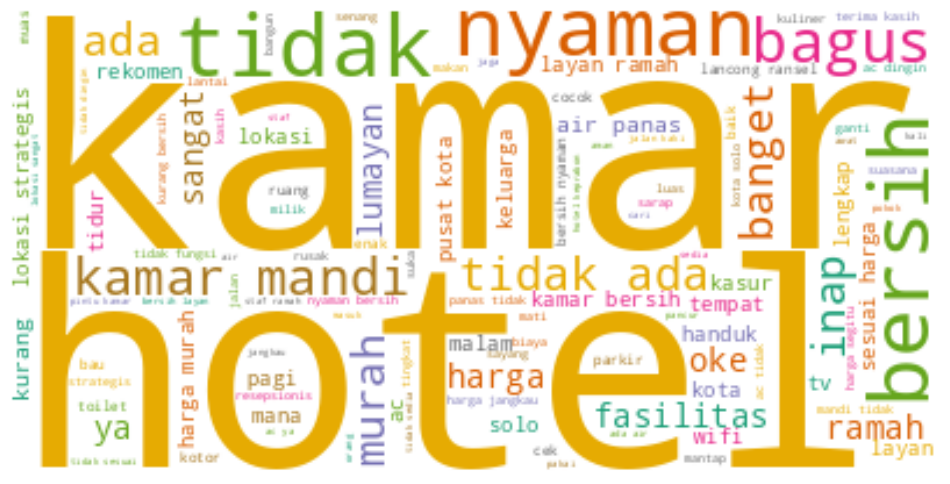

In [ ]:
text = ' '.join(cleaned_data['stemmer'])

wc = WordCloud(background_color='white', colormap='Dark2', max_font_size=150, random_state=42)

wc.generate(text)
plt.figure(figsize=(12, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

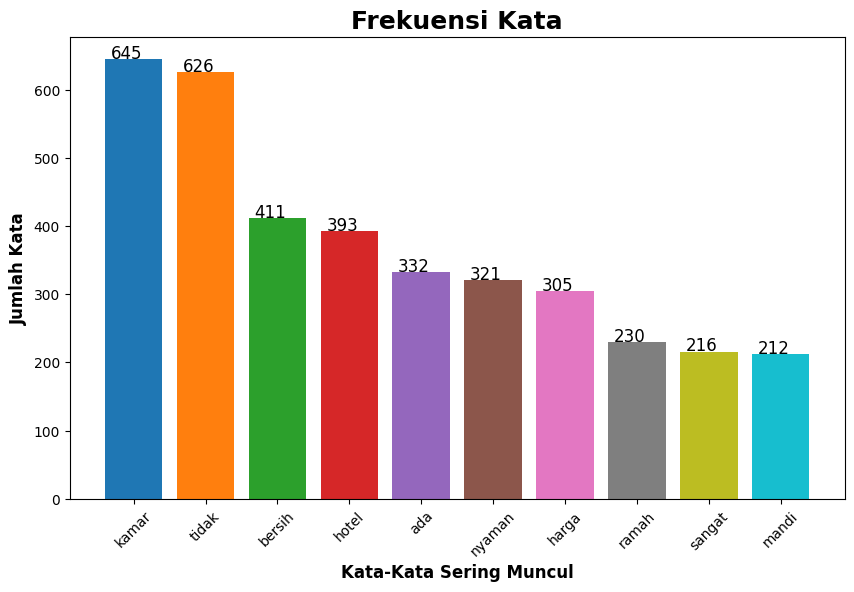

In [ ]:
text = ' '.join(cleaned_data['stemmer'])

tokens = text.split()
word_counts = Counter(tokens)

top_words = word_counts.most_common(10)
word, count = zip(*top_words)
colors = plt.cm.tab10(range(len(word)))


plt.figure(figsize=(10, 6))
bars = plt.bar(word, count, color=colors)
plt.xlabel('Kata-Kata Sering Muncul', fontsize=12, fontweight='bold')
plt.ylabel('Jumlah Kata', fontsize=12, fontweight='bold')
plt.title('Frekuensi Kata', fontsize=18, fontweight='bold')
plt.xticks(rotation=45)

for bar, num in zip(bars, count):
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, num + 1, str(num), fontsize=12, color='black', ha='center')

plt.show()

In [ ]:
import pandas as pd

labeled_data = pd.DataFrame(cleaned_data['stemmer'])

def load_inset_lexicon(filepath=INSET):
    lexicon = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            word, score = line.strip().split('\t')
            lexicon[word] = int(score)
    return lexicon

def label_sentiment(text, lexicon):
    tokens = text.lower().split()
    total_score = 0
    for token in tokens:
        if token in lexicon:
            total_score += lexicon[token]
    if total_score > 0:
        return 'positif'
    else:
        return 'negatif'

inset_lexicon = load_inset_lexicon()
labeled_data['label'] = labeled_data['stemmer'].apply(lambda x: label_sentiment(x, inset_lexicon))
labeled_data.to_excel(LABELED, index=False)
labeled_data


,stemmer,label
0,hotel murah bersih tua awat expect ya properti...,positif
1,harga segitu lumayan lokasi strategis rekomen ...,positif
2,layan sangat ramah hotel nyaman inap,positif
3,puas inap murah tidak murah,positif
4,oke banget inap biaya oke,positif
...,...,...
1217,kurang kota,negatif
1218,ada minibar suasana sangat hangat layan sangat...,positif
1219,ada kecoanya moga depan bagus ac ya dingin,positif
1220,ac tidak nyala air panas alakadarnya,negatif


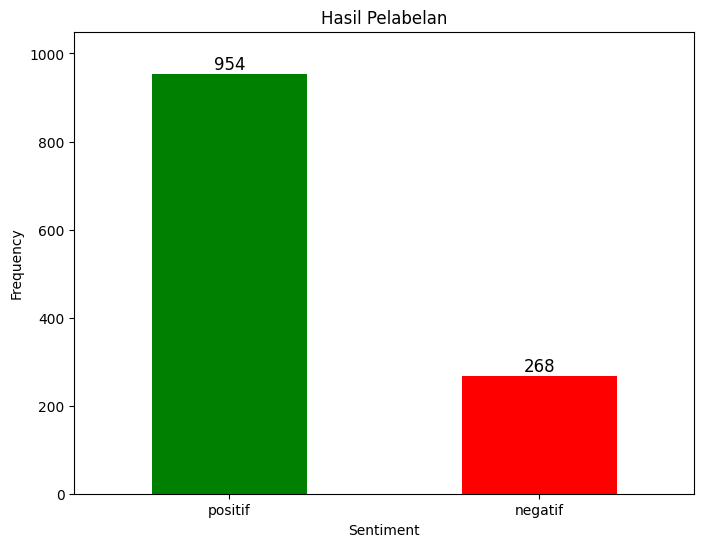

In [ ]:
sentiment_counts = labeled_data['label'].value_counts()

plt.figure(figsize=(8, 6))
ax = sentiment_counts.plot(kind='bar', color=['green', 'red'])

for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=12)

plt.title('Hasil Pelabelan')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.ylim(0, sentiment_counts.max() + sentiment_counts.max()*0.1)
plt.show()

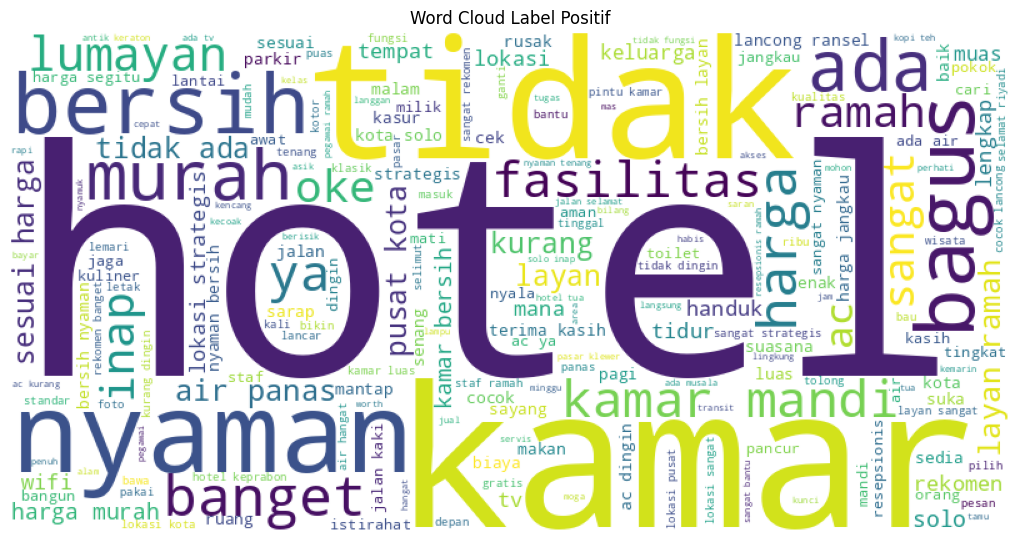

In [ ]:
# Filter dataframe for positive sentiments
positif_df = labeled_data[labeled_data['label'] == 'positif']

# Combine all positive texts
positif_text = " ".join(positif_df['stemmer'])

# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positif_text)

# Display the generated image:
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Word Cloud Label Positif')
plt.show()

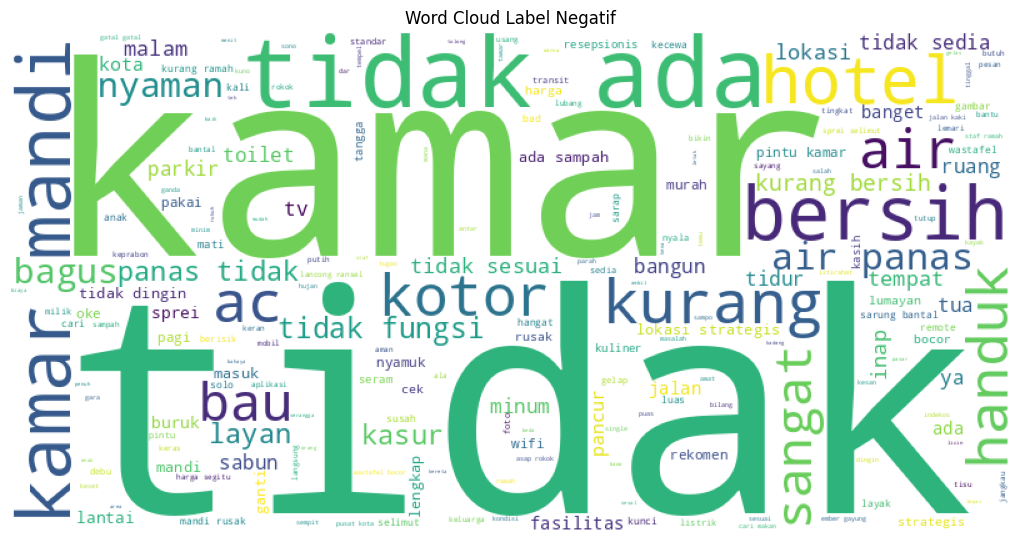

In [ ]:
# Filter dataframe for positive sentiments
negatif_df = labeled_data[labeled_data['label'] == 'negatif']

# Combine all negative texts
negatif_text = " ".join(negatif_df['stemmer'])

# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(negatif_text)

# Display the generated image:
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Word Cloud Label Negatif')
plt.show()

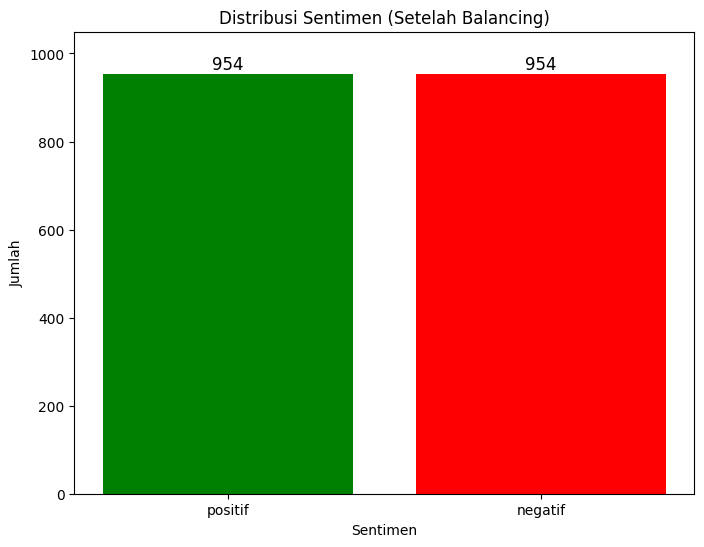

,stemmer,label
0,"[hotel, murah, bersih, tua, awat, expect, ya, ...",positif
1,"[lumayan, harga, segitu, lokasi, strategis, re...",positif
2,"[hotel, ramah, inap, layan, sangat, nyaman]",positif
3,"[murah, inap, puas, tidak]",positif
4,"[banget, inap, oke, biaya]",positif
...,...,...
1903,"[handle, tisu, sampo, sampah, lemari, rusak, b...",negatif
1904,"[tidak, inap, kamar, bersih]",negatif
1905,"[mati, kurang, wifi, tempat, dingin, ac, hotel...",negatif
1906,"[malas, seram, kesan, pinggir, model, lemari, ...",negatif


In [ ]:
from imblearn.over_sampling import SMOTE

X = labeled_data['stemmer']

y = labeled_data['label']

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

smote = SMOTE(random_state=30)
X_resampled, y_resampled = smote.fit_resample(X, y)

balanced_data = pd.DataFrame({'stemmer': vectorizer.inverse_transform(X_resampled), 'label': y_resampled})

sentiment_count_balanced = balanced_data['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(sentiment_count_balanced.index, sentiment_count_balanced.values, color=['green', 'red', 'grey']) # Fallback to matplotlib if seaborn is not available

for i, count in enumerate(sentiment_count_balanced):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=12)

plt.ylim(0, sentiment_count_balanced.max() + sentiment_count_balanced.max()*0.1)

plt.title('Distribusi Sentimen (Setelah Balancing)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

balanced_data.to_csv(BALANCED, index=False)
balanced_data

In [ ]:
balanced_data['stemmer'] = balanced_data['stemmer'].apply(lambda x: ' '.join(x))
balanced_data['stemmer'] = balanced_data['stemmer'].str.replace('[', '').str.replace(']', '').str.replace(',', ' ').str.replace('\'', '')
balanced_data.info()
balanced_data.to_csv(BALANCED, index=False)
balanced_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   stemmer  1908 non-null   object
 1   label    1908 non-null   object
dtypes: object(2)
memory usage: 29.9+ KB


,stemmer,label
0,hotel murah bersih tua awat expect ya properti...,positif
1,lumayan harga segitu lokasi strategis rekomen ...,positif
2,hotel ramah inap layan sangat nyaman,positif
3,murah inap puas tidak,positif
4,banget inap oke biaya,positif
...,...,...
1903,handle tisu sampo sampah lemari rusak bau roko...,negatif
1904,tidak inap kamar bersih,negatif
1905,mati kurang wifi tempat dingin ac hotel ketemu...,negatif
1906,malas seram kesan pinggir model lemari kurang ...,negatif


In [ ]:
tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(balanced_data['stemmer'])

In [ ]:
terms = tfidf.get_feature_names_out()
idf = np.log(tfidf_matrix.shape[0] / (np.count_nonzero(tfidf_matrix.toarray(), axis=0) + 1))

tfidf_df = pd.DataFrame({'term': terms, 'idf': idf})

for i, doc in enumerate(balanced_data['stemmer']):
    tfidf_values = tfidf_matrix[i].toarray().flatten()
    tfidf_df[f'tf{i}'] = tfidf_values

tfidf_df.to_csv(TFIDF, index=False)

/tmp/ipython-input-35-1421458805.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tfidf_df[f'tf{i}'] = tfidf_values
/tmp/ipython-input-35-1421458805.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tfidf_df[f'tf{i}'] = tfidf_values
/tmp/ipython-input-35-1421458805.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

In [ ]:
tfidf_df.info()

tfidf_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Columns: 1910 entries, term to tf1907
dtypes: float64(1909), object(1)
memory usage: 21.5+ MB


,term,idf,tf0,tf1,tf2,tf3,tf4,tf5,tf6,tf7,...,tf1898,tf1899,tf1900,tf1901,tf1902,tf1903,tf1904,tf1905,tf1906,tf1907
0,abon,5.944373,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,abu,6.455199,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,ac,1.763851,0.080416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.125379,0.101175,0.0,0.134611,0.0,0.0
3,acara,6.860664,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,acnya,5.944373,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1470,wongso,6.860664,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1471,wood,6.860664,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1472,worth,4.988861,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1473,xiaomi,6.860664,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [ ]:
result = tfidf.transform(balanced_data['stemmer']).toarray()
result_df = pd.DataFrame(result, columns=tfidf.get_feature_names_out())
result_df

,abon,abu,ac,acara,acnya,ada,adem,adik,affordable,agam,...,wilayah,wisata,wisatawan,wisma,wlw,wongso,wood,worth,xiaomi,ya
0,0.0,0.0,0.080416,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.097144
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,0.0,0.0,0.101175,0.0,0.0,0.088368,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1904,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1905,0.0,0.0,0.134611,0.0,0.0,0.117571,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.162612
1906,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
result = scaler.fit_transform(result_df.iloc[:, :])
length = result_df.shape[1]
result_df = pd.DataFrame(result, columns=[f'word_{i}' for i in range(length)])
result_df['label'] = balanced_data['label'].apply(lambda x: 2 if x == 'positif' else 1 if x == 'netral' else 0)

x = result_df.iloc[:, :-1]
y = result_df.iloc[:, -1]

result_df.info()
result_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Columns: 1476 entries, word_0 to label
dtypes: float64(1475), int64(1)
memory usage: 21.5 MB


,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,...,word_1466,word_1467,word_1468,word_1469,word_1470,word_1471,word_1472,word_1473,word_1474,label
0,0.0,0.0,0.136192,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.187446,2
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,0.0,0.0,0.171348,0.0,0.0,0.192752,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
1904,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
1905,0.0,0.0,0.227975,0.0,0.0,0.256452,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.313772,0
1906,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=57)

print("x_train = ", len(x_train))
print("x_test = ", len(x_test))
print("y_train = ", len(y_train))
print("y_test = ", len(y_test))

x_train =  1526
x_test =  382
y_train =  1526
y_test =  382


In [ ]:
classifier = MultinomialNB()
classifier.fit(x_train, y_train)

MultinomialNB()

In [ ]:
y_pred = classifier.predict(x_test)
y_pred

array([0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0,
       2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0,
       2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2,
       0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0,
       0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2,
       2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0,
       0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0,
       2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2,

In [ ]:
classifier.predict_proba(x_test)

array([[9.89712265e-01, 1.02877347e-02],
       [1.46815878e-01, 8.53184122e-01],
       [9.74952306e-01, 2.50476939e-02],
       [7.37004735e-01, 2.62995265e-01],
       [9.29687213e-01, 7.03127866e-02],
       [9.93553391e-01, 6.44660924e-03],
       [2.68897802e-01, 7.31102198e-01],
       [9.09632341e-01, 9.03676586e-02],
       [5.66956863e-01, 4.33043137e-01],
       [1.13458036e-02, 9.88654196e-01],
       [6.18493781e-01, 3.81506219e-01],
       [1.72708311e-01, 8.27291689e-01],
       [9.99500100e-01, 4.99899673e-04],
       [8.40163150e-01, 1.59836850e-01],
       [8.28249532e-01, 1.71750468e-01],
       [8.28397769e-01, 1.71602231e-01],
       [1.35337182e-01, 8.64662818e-01],
       [9.99999977e-01, 2.28979518e-08],
       [1.09287088e-01, 8.90712912e-01],
       [1.49226758e-01, 8.50773242e-01],
       [9.90304670e-01, 9.69533036e-03],
       [9.99782390e-01, 2.17609591e-04],
       [1.01742633e-01, 8.98257367e-01],
       [1.40008413e-02, 9.85999159e-01],
       [8.824393

In [ ]:
akurasi = classification_report(y_test, y_pred)
print(akurasi)

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       193
           2       0.93      0.84      0.88       189

    accuracy                           0.89       382
   macro avg       0.89      0.89      0.89       382
weighted avg       0.89      0.89      0.89       382



In [ ]:
akurasi = accuracy_score(y_test, y_pred)
print("Tingkat Akurasi: %d persen"%(akurasi*100))

Tingkat Akurasi: 88 persen


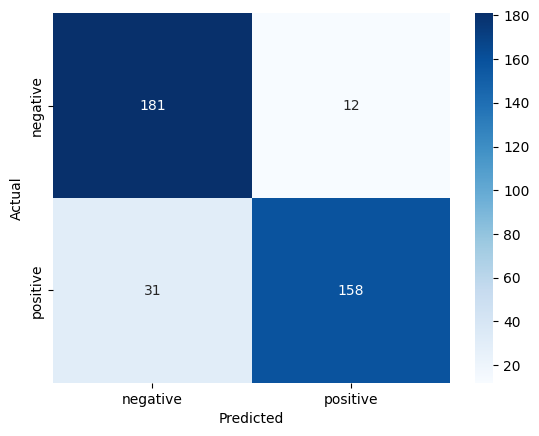

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["negative", "positive"],
    yticklabels=["negative", "positive"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()